In [1]:
import pandas as pd
import numpy as np
import sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to create a more complex LSTM model
def create_complex_lstm_model(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_model, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_
best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")


Best: 0.495614 using {'batch_size': 64, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.434211 (0.049232) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.442982 (0.022364) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.456140 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.434211 (0.037216) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.460526 (0.000000) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.434211 (0.028424) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.456140 (0.043419) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention layer
    x = AttentionLayer()(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_
best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")


Best: 0.464912 using {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.001, 'model__units': 50}
0.429825 (0.022364) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.429825 (0.032822) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.434211 (0.046829) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.425439 (0.027037) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.425439 (0.022364) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.429825 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.464912 (0.012405) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


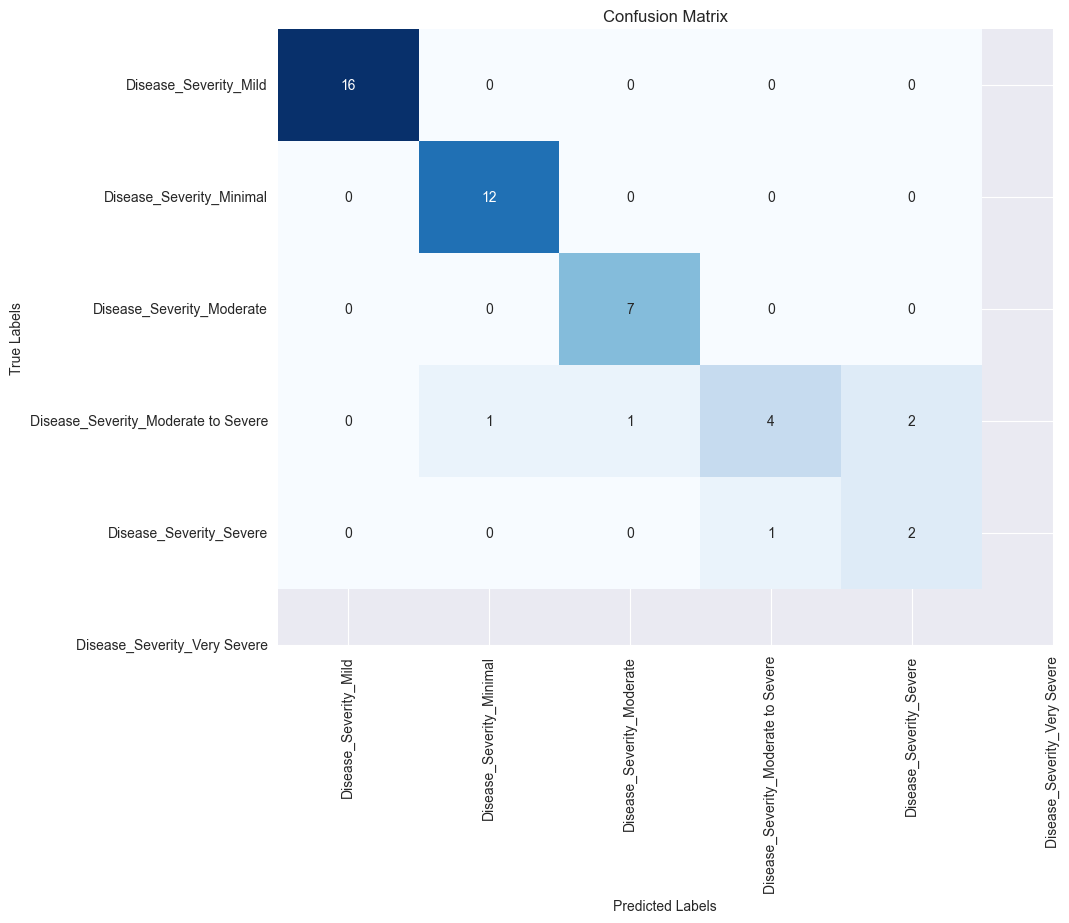

In [6]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_columns, yticklabels=target_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# we will not use it


Best: 0.657895 using {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.574561 (0.079191) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.600877 (0.006203) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.627193 (0.012405) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 200}
0.644737 (0.046829) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.657895 (0.055824) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.635965 (0.086838) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 200}
0.600877 (0.048445) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rat

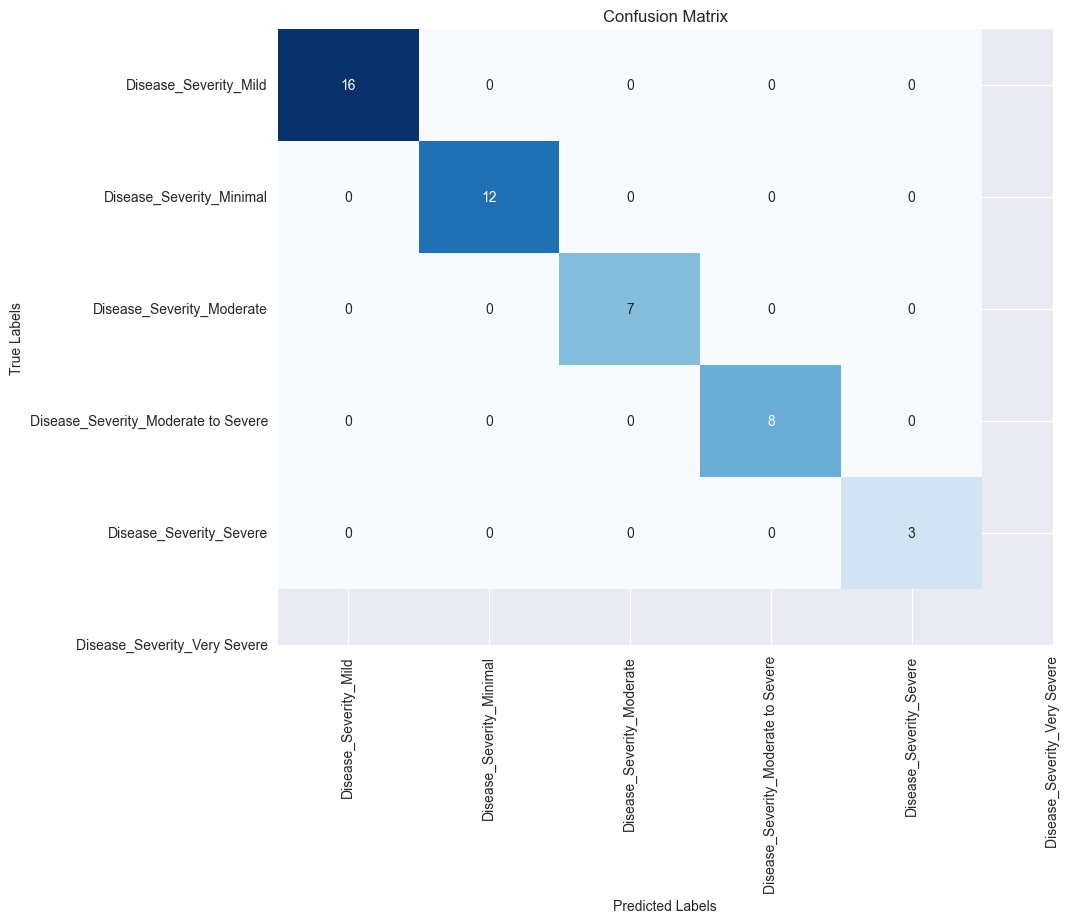

ValueError: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer, Bidirectional, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)

        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)

        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)

        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features,
                                      target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Function to create a more complex LSTM model with attention and bidirectional LSTM
def create_complex_lstm_with_attention(input_shape, output_shape, units=100, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layer
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(inputs)
    x = Dropout(dropout_rate)(x)

    # LSTM layer with attention
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = AttentionLayer()(x)
    x = Dropout(dropout_rate)(x)

    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape,
                        verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [100, 150, 200],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Train and test accuracy
best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")

# Confusion Matrix and Classification Report
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_columns, yticklabels=target_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_classes, y_pred_classes, target_names=target_columns))


Best: 0.666667 using {'batch_size': 64, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.609649 (0.032822) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.627193 (0.065643) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.622807 (0.031013) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 200}
0.605263 (0.083908) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.640351 (0.052996) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.627193 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 200}
0.644737 (0.021487) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_ra

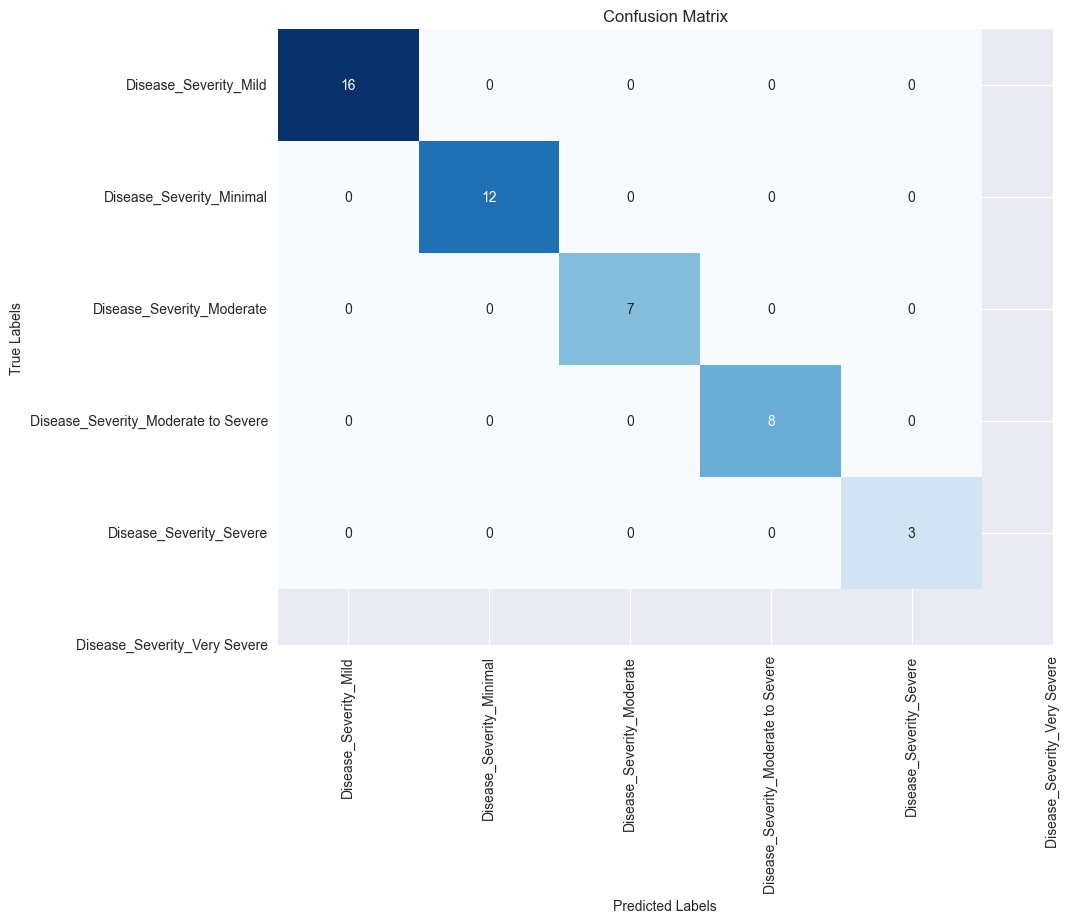

ValueError: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer, Bidirectional, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)

        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)

        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)

        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features,
                                      target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Function to create a more complex LSTM model with attention and bidirectional LSTM
def create_complex_lstm_with_attention(input_shape, output_shape, units=100, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layer
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(inputs)
    x = Dropout(dropout_rate)(x)

    # LSTM layer with attention
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate), activation='relu')(x)
    x = AttentionLayer()(x)
    x = Dropout(dropout_rate)(x)

    # Dense output layer with different activation function
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape,
                        verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [100, 150, 200],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Train and test accuracy
best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")

# Confusion Matrix and Classification Report
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_columns, yticklabels=target_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_classes, y_pred_classes, target_names=target_columns))


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Bidirectional

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First Bidirectional LSTM layer with Batch Normalization
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second Bidirectional LSTM layer with Batch Normalization
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention layer
    x = AttentionLayer()(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_
best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")


Best: 0.526316 using {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.001, 'model__units': 100}
0.456140 (0.031013) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.486842 (0.021487) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.478070 (0.034535) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.464912 (0.006203) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.421053 (0.046829) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.464912 (0.024811) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.500000 (0.037216) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        attention_weights = K.sum(a, axis=1)  # Sum of attention weights for visualization
        return K.sum(output, axis=1), attention_weights

# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention layer
    x, attention_weights = AttentionLayer()(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")


Best: 0.464912 using {'batch_size': 32, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.438596 (0.027037) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.394737 (0.028424) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.407895 (0.037216) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.412281 (0.032822) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.425439 (0.032822) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.438596 (0.037729) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.451754 (0.022364) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate

In [4]:
# Extract attention weights from the model
attention_layer = best_model.get_layer(name='attention_layer_144')  # Ensure the name matches your AttentionLayer definition
attention_model = Model(inputs=best_model.input, outputs=attention_layer.output[1])
attention_weights = attention_model.predict(X_test)

# Visualize or analyze attention weights as needed
print("Attention Weights for the first sample in the test set:")
print(attention_weights[2])  # Replace 0 with index if you want to see attention weights for a specific sample

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Attention Weights for the first sample in the test set:
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.9999999  1.         1.
 1.         1.         0.99999994 0.9999999  0.99999994 1.
 1.         1.         1.0000001  1.         1.         1.
 1.         1.         1.         1.         1.0000001  1.
 1.         1.         0.9999999  1.         1.         1.
 0.99999994 1.         1.         1.         1.0000001  1.
 1.         1.         0.99999994 1.         1.         1.
 1.         1.         0.9999999  1.         1.         1.
 1.         1.         1.         1.         0.99999994 1.
 1.         0.99999994 1.         1.0000001  1.         1.
 1.         0.9999999  1.0000001  1.         1.         1.
 1.         1.         0.99999994 1.         1.         1.
 1.0000001  1.         1.         0.9999999  1.         1.
 0.99999994 1.         1.         1.         1.0000001  0.9999999
 1.         0

In [29]:
# Assuming you want to correlate with the first feature across all visits
first_feature = X_test[:, 0, 1]  # Adjust the index (0, 0) based on your input features

# Calculate the correlation between attention weights and the first feature
correlation = np.mean(attention_weights * first_feature[:, np.newaxis], axis=1)

# Get the indices of the top features (those with highest correlation)
top_indices = np.argsort(correlation)[-10:]  # Adjust the number (5) based on how many top features you want to print
print("Top feature indices based on correlation with attention weights:", top_indices)


Top feature indices based on correlation with attention weights: [26 42 41  0 44  2 30 40 35 38]


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K
import tensorflow as tf

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        attention_weights = K.sum(a, axis=1)  # Sum of attention weights for visualization
        return K.sum(output, axis=1), attention_weights

# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention layer
    x, attention_weights = AttentionLayer()(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Testing Loss: {test_loss:.4f}")



Best: 0.469298 using {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.001, 'model__units': 150}
0.429825 (0.055131) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.421053 (0.032230) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.421053 (0.010743) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.442982 (0.012405) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.442982 (0.037729) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.434211 (0.018608) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.447368 (0.018608) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        attention_weights = tf.keras.backend.sum(a, axis=1)  # Sum of attention weights for visualization
        return tf.keras.backend.sum(output, axis=1), attention_weights

# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second bidirectional LSTM layer with Batch Normalization
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention layer
    x, attention_weights = AttentionLayer()(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}  Training Loss: {train_loss:.4f}")


# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_acc:.4f}  Testing Loss: {test_loss:.4f}")

# Predict using the best model
y_pred = best_model.predict(X_test)

# Extract attention weights from the model
attention_layer = best_model.model.layers[-2]  # Access layers directly from best_model
get_attention_weights = tf.keras.backend.function([best_model.model.input], [attention_layer.output[1]])

# Calculate attention weights for test data
attention_weights = get_attention_weights([X_test])[0]

# Visualize or analyze attention weights as needed
print("Attention Weights for the first sample in the test set:")
print(attention_weights[0])  # Replace 0 with index if you want to see attention weights for a specific sample


Best: 0.504386 using {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.001, 'model__units': 50}
0.456140 (0.022364) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.438596 (0.054074) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.478070 (0.027037) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.447368 (0.021487) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.447368 (0.010743) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.464912 (0.034535) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.504386 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

AttributeError: 'Functional' object has no attribute 'model'

Best: 0.504386 using {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.001, 'model__units': 50}
0.456140 (0.022364) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.438596 (0.054074) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.478070 (0.027037) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.447368 (0.021487) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.447368 (0.010743) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.464912 (0.034535) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.504386 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

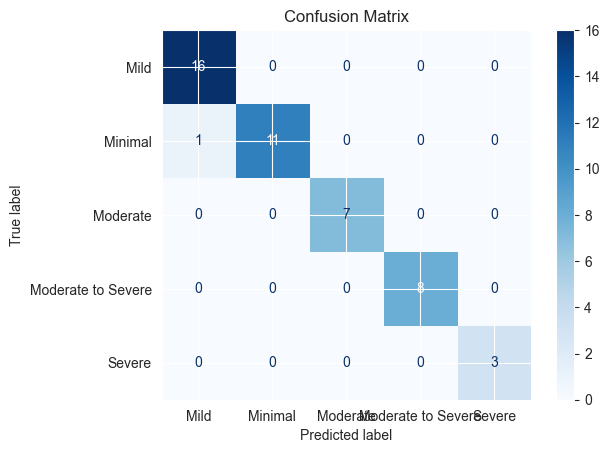

Classification Report:
                    precision    recall  f1-score   support

              Mild       0.94      1.00      0.97        16
           Minimal       1.00      0.92      0.96        12
          Moderate       1.00      1.00      1.00         7
Moderate to Severe       1.00      1.00      1.00         8
            Severe       1.00      1.00      1.00         3

          accuracy                           0.98        46
         macro avg       0.99      0.98      0.99        46
      weighted avg       0.98      0.98      0.98        46
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 880ms/step
Attention Weights for the first sample in the test set:
[0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.0000001  1.         1.         1.0000001  1.         0.99999994
 1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         0.99999994 1.         1.
 1.         1.         1.         0.9

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

# Print the best parameters and score from GridSearchCV
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}  Training Loss: {train_loss:.4f}")

# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_acc:.4f}  Testing Loss: {test_loss:.4f}")

# Predict using the best model
y_pred = best_model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
y_test_classes = y_test.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

# Define the class labels with the prefix removed
target_columns = list(data.filter(regex='Disease_Severity').columns)
cleaned_labels = [label.replace('Disease_Severity_', '') for label in target_columns]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cleaned_labels[:len(set(y_test_classes))])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=cleaned_labels[:len(set(y_test_classes))]))

# Extract attention weights from the model
attention_layer = best_model.get_layer(name='attention_layer_144')  # Ensure the name matches your AttentionLayer definition
attention_model = Model(inputs=best_model.input, outputs=attention_layer.output[1])
attention_weights = attention_model.predict(X_test)

# Visualize or analyze attention weights as needed
print("Attention Weights for the first sample in the test set:")
print(attention_weights[2])  # Replace 0 with index if you want to see attention weights for a specific sample


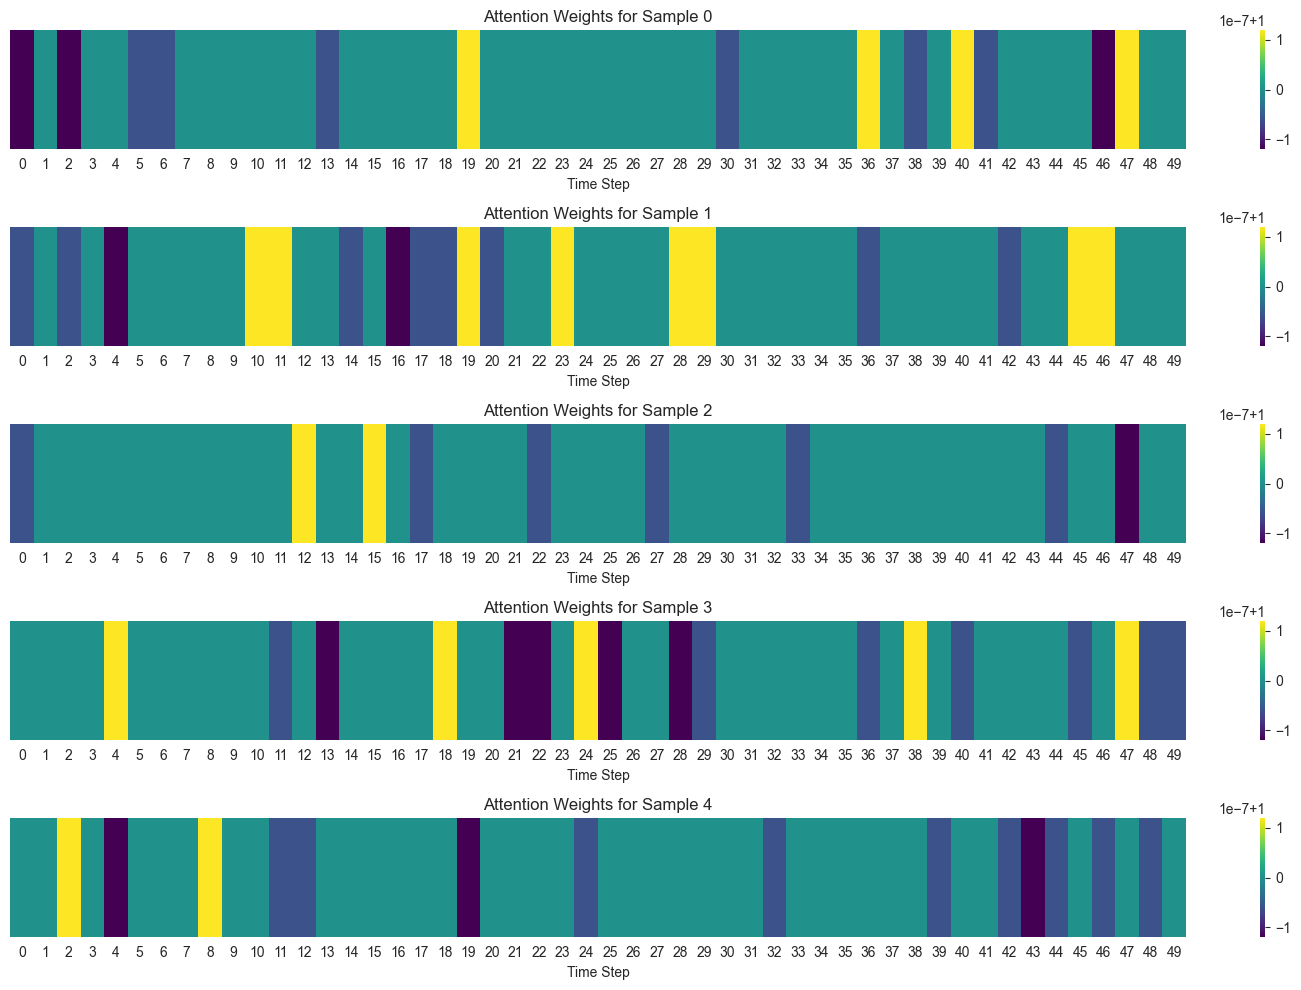

In [16]:
import numpy as np
import seaborn as sns

# Function to plot attention weights
def plot_attention_weights(attention_weights, sample_index, ax):
    sns.heatmap(np.expand_dims(attention_weights[sample_index], axis=0), cmap="viridis", cbar=True, ax=ax)
    ax.set_title(f'Attention Weights for Sample {sample_index}')
    ax.set_xlabel('Time Step')
    ax.set_yticks([])

# Plot attention weights for the first 5 samples
fig, axs = plt.subplots(5, 1, figsize=(15, 10))
for i in range(5):
    plot_attention_weights(attention_weights, i, axs[i])
plt.tight_layout()
plt.show()


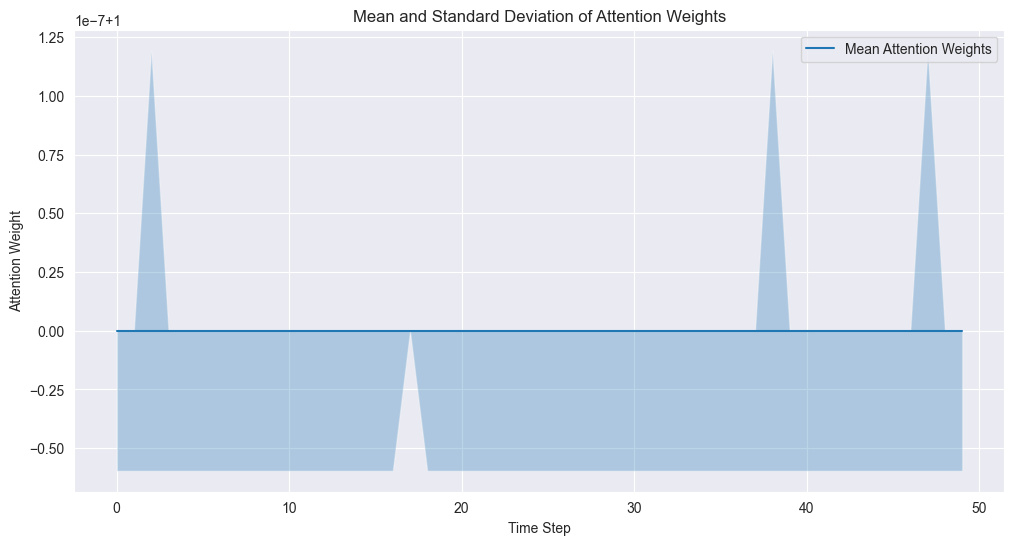

In [21]:
# Calculate the mean and standard deviation of attention weights across all samples and time steps
mean_attention_weights = np.mean(attention_weights, axis=0)
std_attention_weights = np.std(attention_weights, axis=0)

# Plot the mean and standard deviation of attention weights
plt.figure(figsize=(12, 6))
plt.plot(mean_attention_weights, label='Mean Attention Weights')
plt.fill_between(np.arange(len(mean_attention_weights)), 
                 mean_attention_weights - std_attention_weights, 
                 mean_attention_weights + std_attention_weights, alpha=0.3)
plt.title('Mean and Standard Deviation of Attention Weights')
plt.xlabel('Time Step')
plt.ylabel('Attention Weight')
plt.legend()
plt.show()


In [23]:
# Calculate summary statistics
mean_attention = np.mean(attention_weights)
median_attention = np.median(attention_weights)
std_attention = np.std(attention_weights)

print(f'Mean Attention Weight: {mean_attention:.4f}')
print(f'Median Attention Weight: {median_attention:.4f}')
print(f'Standard Deviation of Attention Weights: {std_attention:.4f}')


Mean Attention Weight: 1.0000
Median Attention Weight: 1.0000
Standard Deviation of Attention Weights: 0.0000


Mean Attention Weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Median Attention Weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Standard Deviation of Attention Weights: [4.9151250e-08 5.8400385e-08 3.5762788e-08 5.7788846e-08 4.5393545e-08
 4.7683717e-08 4.3800291e-08 5.1962125e-08 4.1295309e-08 4.9868824e-08
 5.5275073e-08 3.6742769e-08 5.9005590e-08 4.9151250e-08 4.5393545e-08
 4.7683717e-08 5.4628558e-08 5.3974301e-08 4.9868824e-08 5.0576219e-08
 5.3312014e-08 2.3841858e-08 4.5393545e-08 3.9537248e-08 4.4604032e-08
 4.4604032e-08 5.8400385e-08 4.7683717e-08 4.7683717e-08 3.9537248e-08
 7.2512179e-08 4.7683717e-08 4.6932744e-08 4.8423043e-08 4.6932744e-08
 5.3974301e-08 4.4604032e-08 4.8423043e-08 5.6545929e-08 5.0576219e-08
 3.9537248e-08 3.1539813e-08 5.1273854e-08 5.0576219e-08 4.

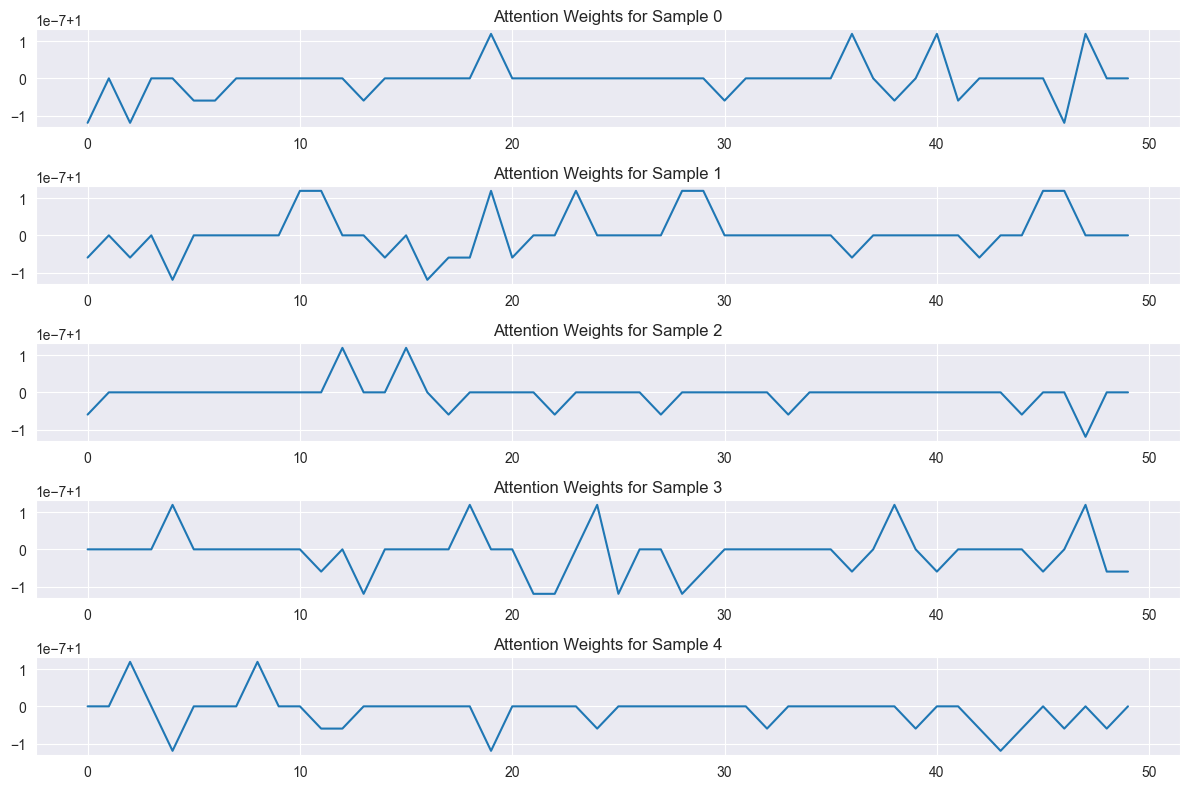

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Convert attention weights to numpy array for easier manipulation
attention_weights_np = np.array(attention_weights)

# Compute statistical metrics for each sample
mean_attention = np.mean(attention_weights_np, axis=1)
median_attention = np.median(attention_weights_np, axis=1)
std_attention = np.std(attention_weights_np, axis=1)

# Print the computed metrics
print("Mean Attention Weights:", mean_attention)
print("Median Attention Weights:", median_attention)
print("Standard Deviation of Attention Weights:", std_attention)

# Plot the attention weights for a few samples
num_samples_to_plot = 5
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(attention_weights_np[i])
    plt.title(f"Attention Weights for Sample {i}")
plt.tight_layout()
plt.show()


In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Bidirectional
# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)


# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)

        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)

        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)

        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets


# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features,
                                      target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)

    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Second LSTM layer with Batch Normalization
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(x)
    # x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Attention layer
    x = AttentionLayer()(x)

    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape,
                        verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx


# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_
best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")

Best: 0.495614 using {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.01, 'model__units': 100}
0.464912 (0.012405) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.425439 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.460526 (0.018608) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.473684 (0.042974) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.442982 (0.006203) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.473684 (0.000000) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.469298 (0.037729) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

Best: 0.491401 using {'batch_size': 64, 'epochs': 50, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.001, 'model__units': 50}
0.425604 (0.085483) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.429952 (0.095051) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.438551 (0.094038) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.456329 (0.105390) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.455942 (0.088558) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.456425 (0.114011) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.460097 (0.107671) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

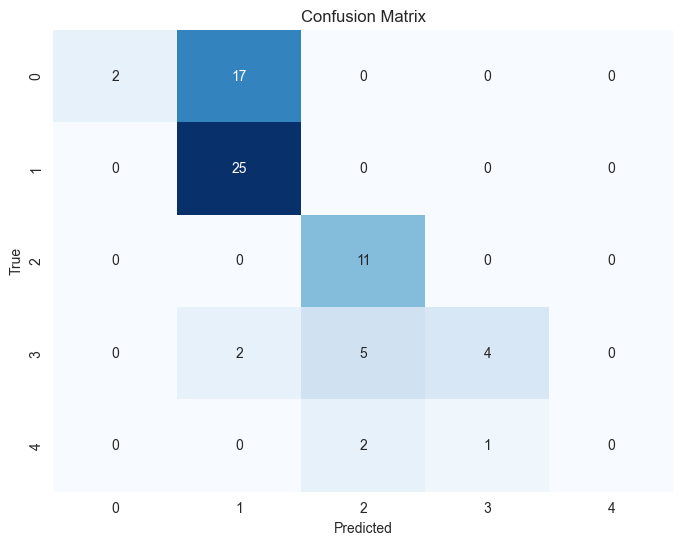

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)


# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)

        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)

        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)

        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets


# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features,
                                      target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)

    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Second LSTM layer with Batch Normalization
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Attention layer
    x = AttentionLayer()(x)

    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape,
                        verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with KFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf.split(X))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_
best_model_train_loss, best_model_train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
best_model_test_loss, best_model_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Best Model - Train Loss: {best_model_train_loss}, Train Accuracy: {best_model_train_accuracy}")
print(f"Best Model - Test Loss: {best_model_test_loss}, Test Accuracy: {best_model_test_accuracy}")

# Plot confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
